In [ ]:
from pymed import PubMed
from concurrent.futures import ThreadPoolExecutor
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

farmacos = pd.read_csv("../data/farmacos.csv", header=None, names=['Farmaco'])
tumores = pd.read_csv("../data/tipo_tumores.csv", header=None, names=['TipoTumor'])

# Función para obtener el número de resultados de pubmed
def get_results_count(query):
    pubmed = PubMed(tool="MyTool", email="b.mascat@gmail.com")
    return pubmed.getTotalResultsCount(query)

# Función para procesar una única combinación de enfermedades y fármacos
def process_combination(disease, drug):
    query = f"{disease} AND {drug}"
    results_count = get_results_count(query)
    return {f'{disease.columns[0]}': disease, f'{drug.colums[0]}': drug, 'Results': results_count}



In [2]:
#Funcion de preprocesado de datos

def data_preprocessing(results_df, rows = "farmaco", columns = "term", cellValues = "count", num_top_events = 12):
    #Preprocesamieto del dataframe

    # Utilizamos la función pivot_table (gestiona duplicados) para convertir el DataFrame largo a uno ancho
    results_df_wide = results_df.pivot_table(index=rows, columns=columns, values=cellValues)

    #Se elimina la etiqueta farmaco como nombre de columna
    results_df_wide.columns.name = None

    #Se resetea los indices para que Tipo de tumor y los nombres de los farmacos esten al mismo nivel
    results_df_wide.reset_index(inplace=True)

    #Se extraen los 25 eventos con mayor número de resultados en la bibliografía. Independientemente del tipo de tumor 
    top_events = results_df_wide.drop(columns=[rows]).sum().sort_values(ascending=False).head(num_top_events)

    #Filtra el dataframe para quedarte solo con la columna de tipo de tumor y los farmacos con más resultados
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]

    #Define el tipo de tumor como los indices del dataframe
    results_df_wide.set_index(rows, inplace=True)

    # Suma el total de resultados de los 15 fármacos para cada tipo de tumor y crea una nueva columna llamada 'TotalResultados'
    results_df_wide['TotalResultados'] = results_df_wide[list(top_events.index)].sum(axis=1)

    # Ordena el DataFrame por la nueva columna 'TotalResultados' en orden descendente
    results_df_wide = results_df_wide.sort_values(by='TotalResultados', ascending=False).reset_index()
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]
    results_df_wide.set_index(rows, inplace=True)

    results_df = results_df_wide.fillna(0)
    
    return results_df, top_events

def bar_plot_results(results_df_wide, top_events, num_columns = 25, xlab = 'Fármacos', 
                     plot_title ='Farmacos y efecto adverso. Source:Faers', legend_title = 'Efecto adverso'):
    # Visualizar los resultados de cada farmaco en función del tipo de tumor

    # Configura la paleta de colores única para cada fármaco con Seaborn
    colors = sns.color_palette("Set3", n_colors=len(top_events))

    # Creamos un gráfico de barras apiladas
    ax = results_df_wide.head(num_columns).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

    # Añadimos etiquetas y título
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel('Número de Resultados', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.legend(title= legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')  # Colocar la leyenda a la derecha
    plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
    plt.tight_layout()  # Ajustar el diseño del gráfico
    plt.show()
    
def iterative_pubmed_search(first_list, second_list):
    # Inicializar una lista para almacenar los resultados
    results_list = []

    # Bucle anidado para combinar tipos de tumor y fármacos
    for first_list_element in first_list[first_list.columns[0]]:
        for second_list_element in second_list[second_list.columns[0]]:
            # Crear la consulta combinando el tipo de tumor y el fármaco
            query = f"{first_list_element} AND {second_list_element}"
            # Obtener el número de resultados
            results_count = get_results_count(query)
            # Agregar los resultados a la lista
            results_list.append({f'{first_list.columns[0]}': first_list_element, f'{second_list.columns[0]}': second_list_element, 'Resultados': results_count})

    # Crear un DataFrame a partir de la lista de resultados
    results_df = pd.DataFrame(results_list)
    return results_df
    

In [ ]:
results_df = iterative_pubmed_search(tumores, farmacos)

# Mostrar el DataFrame final
print("DataFrame de Resultados:")
print(results_df)

In [21]:
#Salvar resultados de la búsqueda en pubmed en .csv
results_df.to_csv('../results/resultados_pubmed.csv', index=False)

In [ ]:
# Crear una lista de combinaciones de tipos de tumor y fármacos
combinations = [(tipo_tumor, farmaco) for tipo_tumor in tumores['TipoTumor'] for farmaco in farmacos['Farmaco']]

# Utilizar ThreadPoolExecutor para procesar las combinaciones en paralelo
with ThreadPoolExecutor() as executor:
    for combination in combinations:
        results_list.append(executor.submit(lambda x: process_combination(*x), combination).result())
        time.sleep(1)  # Esperar 1 segundo entre cada solicitud


# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Mostrar el DataFrame final
print("DataFrame de Resultados:")
print(results_df)

In [6]:
results_df = pd.read_csv("../results/resultados_pubmed.csv")

In [7]:
#Preprocesado del dataframe 
results_df_wide, top_farmacos = data_preprocessing(results_df, rows = "TipoTumor", columns = "Farmaco", cellValues = "Resultados", num_top_events = 12)

results_df_wide

,FLUOROURACILO,GEMCITABINA,OXALIPLATINO,PACLITAXEL,IRINOTECAN,CAPECITABINA,DOXORUBICINA,BEVACIZUMAB,TRASTuzumab,CETUXIMAB,CARBOPLATINO,EVEROLIMUS
TipoTumor,,,,,,,,,,,,
Pancreatic Adenocarcinoma,2178,3920,795,973,745,333,371,144,50,95,98,87
Gastric Adenocarcinoma,2562,128,671,591,362,435,568,86,463,43,118,22
Colorectal Adenocarcinoma,1937,79,834,81,569,363,203,386,37,296,52,13
Esophageal Squamous Cell Carcinoma,1623,30,66,478,86,52,114,16,33,67,192,7
Esophageal Adenocarcinoma,981,46,261,343,143,184,169,61,209,51,181,11
Rectal Adenocarcinoma,1362,14,350,22,151,365,53,139,3,63,31,0
Colorectal Carcinoma Invasive,848,20,355,55,153,136,74,168,15,137,15,4
Pancreatic Neuroendocrine Tumor,227,54,42,27,38,136,76,66,5,6,40,462
Duodenal Adenocarcinoma,187,96,48,24,27,45,28,17,20,6,9,2


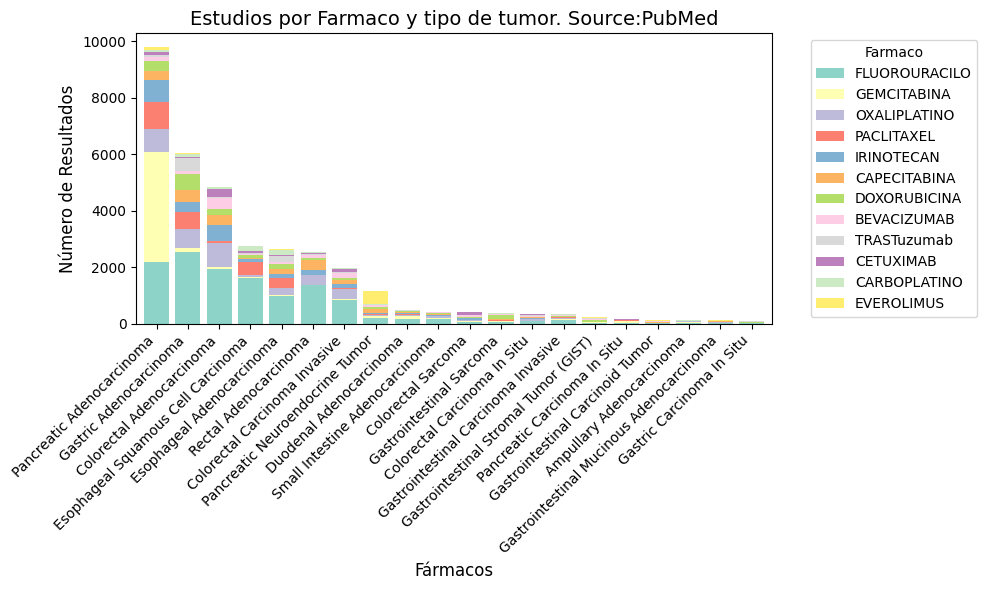

In [8]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor

bar_plot_results(results_df_wide, top_farmacos, num_columns = 20, xlab = 'Fármacos', 
                     plot_title ='Estudios por Farmaco y tipo de tumor. Source:PubMed', legend_title = 'Farmaco')

In [ ]:
# Inicializar una lista para almacenar los resultados
results_list = []
adverseEffects = ["sarcopenia", "dysphagia"]

# Bucle anidado para combinar efecto adverso y fármacos
for adverseEffect in adverseEffects:
    for drug in farmacos['Farmaco']:
        # Crear la consulta combinando el tipo de tumor y el fármaco
        query = f"{adverseEffect} AND {drug}"
        # Obtener el número de resultados
        results_count = get_results_count(query)
        # Agregar los resultados a la lista
        results_list.append({'Efecto adverso': adverseEffect, 'Farmaco': drug, 'Resultados': results_count})

# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

In [17]:
#Salvar resultados de la búsqueda en pubmed en .csv
results_df.to_csv('../results/resultados_pubmed_efectos_adversos.csv', index=False)

In [10]:
#Cargar datos de los efectos adversos en la bibliografía
results_df = pd.read_csv("../results/resultados_pubmed_efectos_adversos.csv")
results_df

,Efecto adverso,Farmaco,Resultados
0,sarcopenia,pembrolizumab,12
1,sarcopenia,osimertinib,0
2,sarcopenia,nivolumab,16
3,sarcopenia,abemaciclib,1
4,sarcopenia,emtansine trastuzumab,0
...,...,...,...
123,dysphagia,alpelisib,1
124,dysphagia,rucaparib,0
125,dysphagia,temozolomide,3
126,dysphagia,oxaliplatin,36


In [11]:
#Preprocesamieto del dataframe

results_df_wide, top_farmacos = data_preprocessing(results_df, rows = "Farmaco", columns = "Efecto adverso", cellValues = "Resultados", num_top_events = 12)

results_df_wide

,dysphagia,sarcopenia
Farmaco,,
fluorouracil,325,42
paclitaxel,107,24
carboplatin,111,16
doxorubicin,86,28
sodium chloride,70,4
...,...,...
olaparib,0,0
deruxtecan trastuzumab,0,0
emtansine trastuzumab,0,0


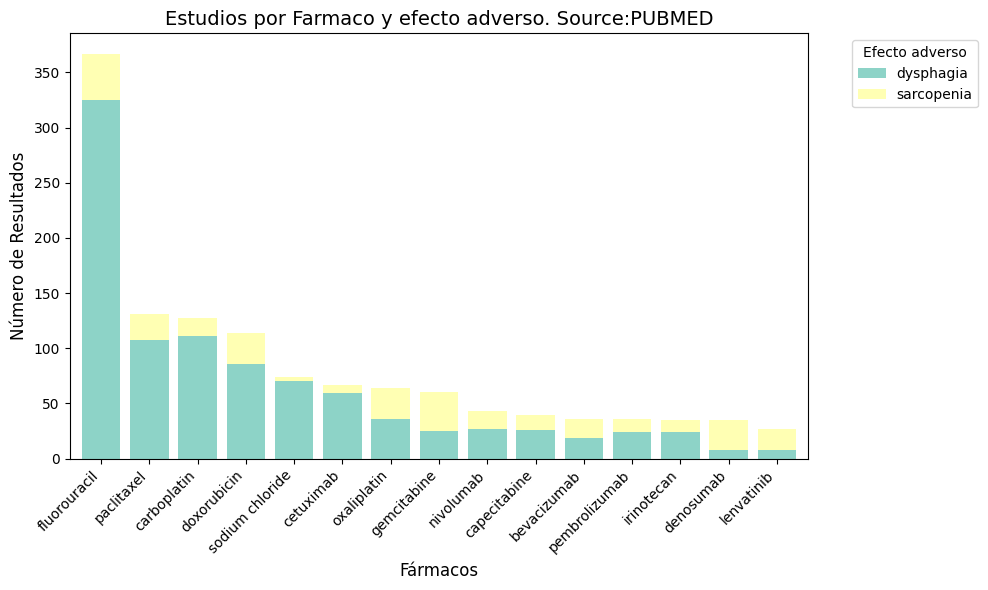

In [12]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor

bar_plot_results(results_df_wide, top_farmacos, num_columns = 15, xlab = 'Fármacos', 
                     plot_title ='Estudios por Farmaco y efecto adverso. Source:PUBMED', legend_title = 'Efecto adverso')